# Supervised Learning with Decision Trees: The Iris Dataset


In this guide, we'll explore how decision trees classify data using the classic Iris dataset. We'll cover loading data, training a model, evaluating results, and visualizing the decision-making process. 


**1. Import Libraries**

In [144]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import tree
import matplotlib.pyplot as plt

* **pandas:** For loading and working with tabular data.
* **sklearn.datasets:** Access to built-in datasets.
* **sklearn.model_selection:** To split data into training/testing sets.
* **sklearn.tree:** For building and visualizing decision trees.
* **sklearn.metrics:** Evaluation tools.
* **matplotlib.pyplot:** For plotting.
* **graphviz:** Creates visual graphs of the tree (install with `pip install graphviz`).

**2. Load the Iris Dataset**

In [145]:
iris = load_iris()
X = iris.data  # Features: sepal length, sepal width, petal length, petal width
y = iris.target  # Target: species  (0 - setosa, 1 - versicolor, 2 - virginica)

* The Iris dataset has 150 flower samples.
* **Features (`X`)**: Sepal length/width, petal length/width.
* **Target (`y`)**: Species (0: setosa, 1: versicolor, 2: virginica).

**3. Split Data** 

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

* We split into  80% training data for model learning, and 20% testing data for evaluation.
* `random_state` ensures the same  split if you re-run the code.

**4. Create and Train the Model**

In [147]:
# Create and Train the Model with no max_depth limit to make the full tree
clf_full = DecisionTreeClassifier(random_state=42) 
clf_full.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

**5. Predictions and Evaluation**

In [148]:
y_pred = clf_full.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



* The model makes predictions on unseen test data.
* **Accuracy:** The proportion of correct predictions.
* **Confusion Matrix:** Visualizes errors by class.
* **Classification Report:** Gives precision, recall, and F1-score.



**6. Cross-Validation** 

Cross-validation provides a better assessment of the model's performance across different subsets of the data.

In [149]:
scores = cross_val_score(clf_full, X, y, cv=5)
print("Cross-validation scores:", scores.mean())


Cross-validation scores: 0.9533333333333334


**7. Feature Importance**

Understanding which features contribute most to decisions can offer insights into the dataset.

In [150]:
# Feature Importance
print("Feature Importance:")
for i, j in enumerate(clf_full.feature_importances_):
    print(f'Feature: {iris.feature_names[i]}, Score: {j:.2f}')

Feature Importance:
Feature: sepal length (cm), Score: 0.00
Feature: sepal width (cm), Score: 0.02
Feature: petal length (cm), Score: 0.91
Feature: petal width (cm), Score: 0.08


**8. Visualize the Decision Tree** 

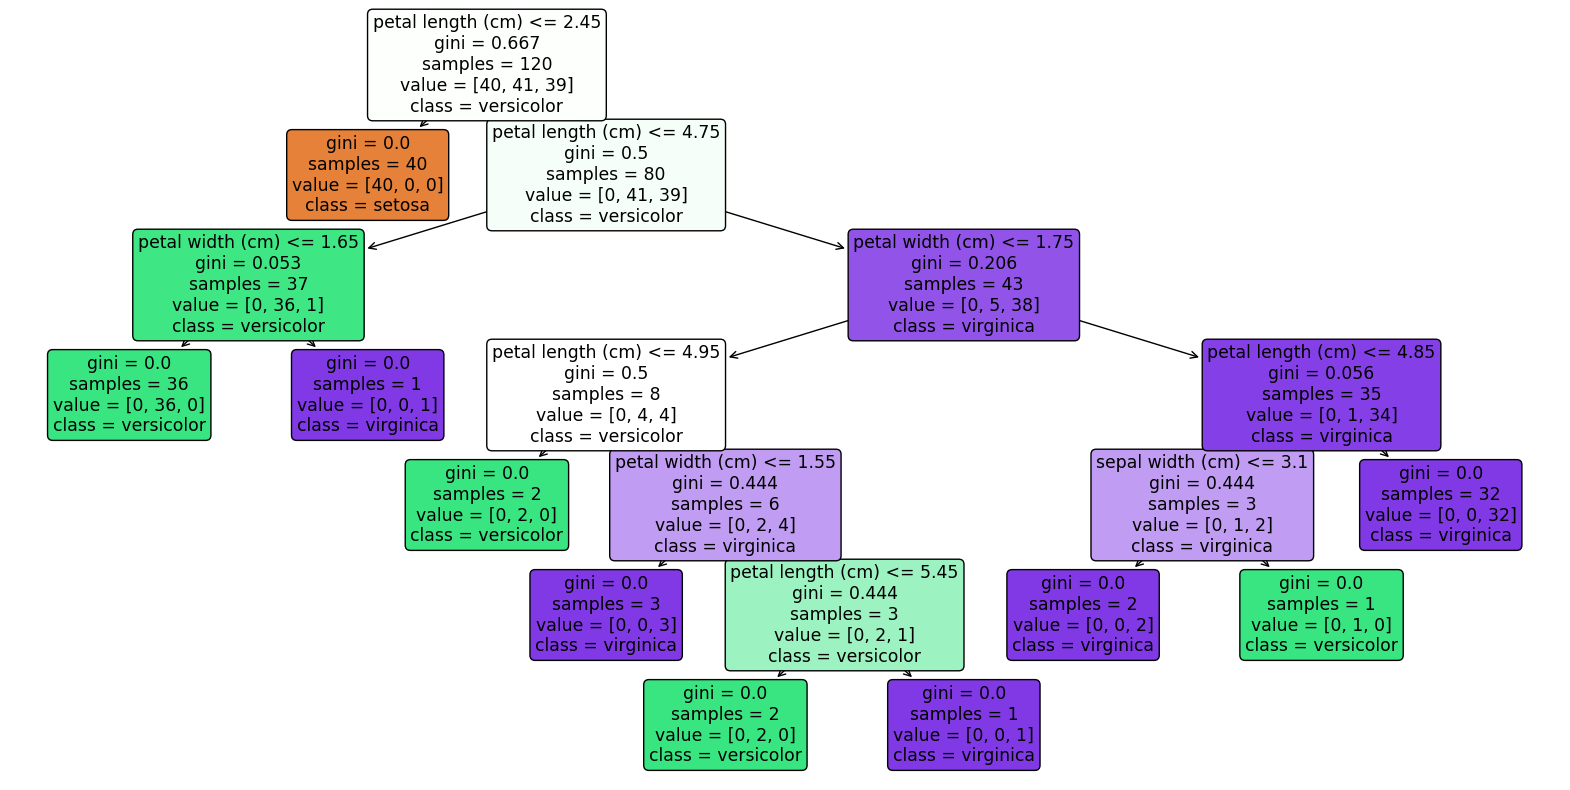

In [151]:
# Visualize the Decision Tree
plt.figure(figsize=(20,10))
tree.plot_tree(
    clf_full, 
    filled=True, 
    rounded=True, 
    feature_names=iris.feature_names, 
    class_names=iris.target_names
)
plt.show()

**9. Prune The Tree**

In [152]:
# Pruning the tree using cost complexity pruning to get the best alpha
path = clf_full.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# Remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node.
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

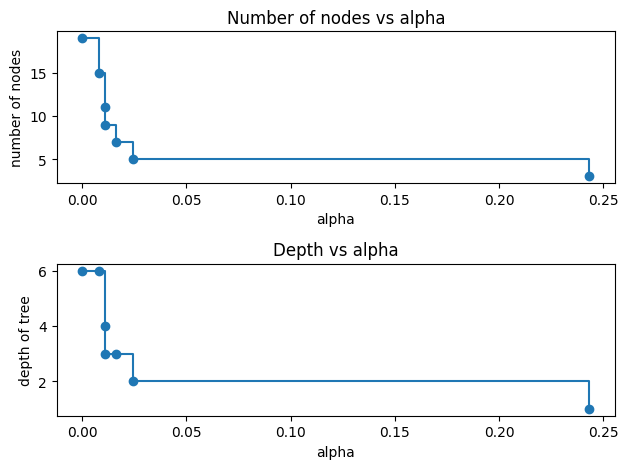

In [153]:
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [158]:
ccp_alphas, ccp_alphas[-2]

(array([0.        , 0.00809524, 0.01111111, 0.01111111, 0.01621622,
        0.0241196 , 0.24326537]),
 0.024119601328903645)

In [159]:
# Use the ccp_alpha value that gives the best cross-validation score
clf_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alphas[-2])
clf_pruned.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.024119601328903645, random_state=42)

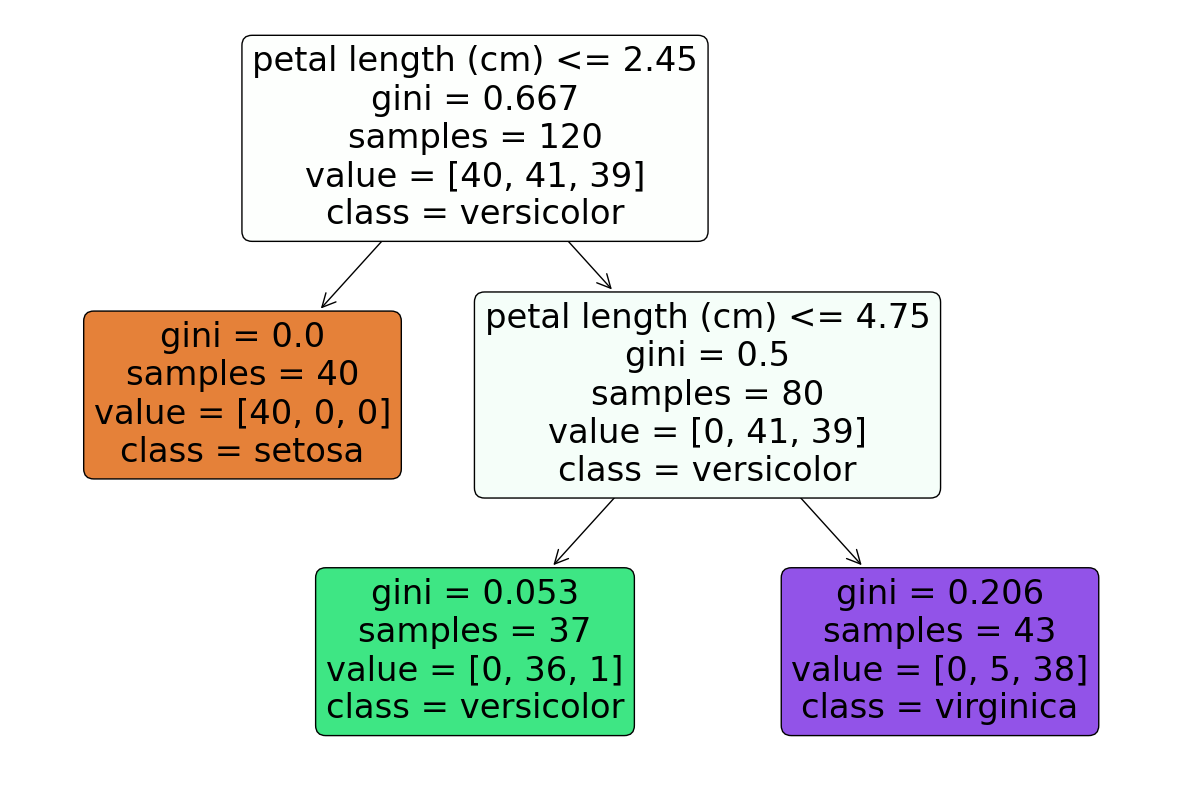

In [160]:
# Display pruned tree
plt.figure(figsize=(15,10))
tree.plot_tree(clf_pruned, filled=True, rounded=True, feature_names=iris.feature_names, class_names=iris.target_names)
plt.show()

**10. Evaluate the Pruned Tree**

In [161]:
y_pred = clf_pruned.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.89      0.94         9
           2       0.92      1.00      0.96        11

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



In [165]:
scores = cross_val_score(clf_pruned, X, y, cv=5)
print("Cross-validation scores:", scores.mean())


Cross-validation scores: 0.9466666666666667


**11. Visualize Decision Boundaries**

In [162]:
def plot_decision_boundary(clf, X, y, ax, title="Decision Boundary"):
    # Plotting decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    contour = ax.contourf(xx, yy, Z, alpha=0.4, 
                          levels=np.arange(len(np.unique(y)) + 1) - 0.5, 
                          cmap="viridis")
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap="viridis")
    
    ax.set_xlabel('Petal length (cm)')
    ax.set_ylabel('Petal width (cm)')
    ax.set_title(title)
    
    # Produce a legend with the unique colors from the scatter
    legend = ax.legend(*scatter.legend_elements(), title="Species")
    ax.add_artist(legend)

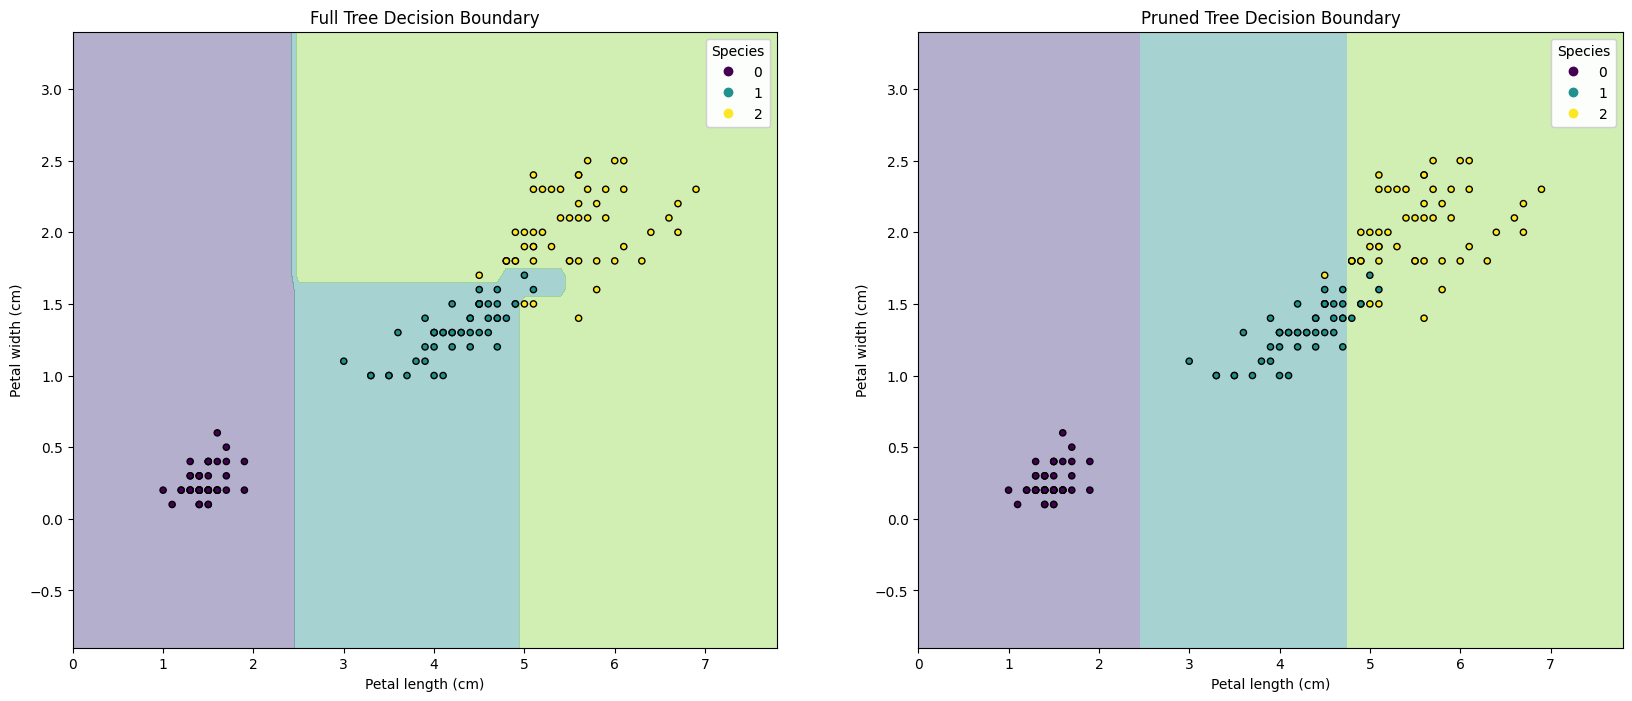

In [163]:
# We now only take petal length and petal width as features since they
# are the most important features
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

clf_full = DecisionTreeClassifier(random_state=42)
clf_full.fit(X_train[:, 2:4], y_train)
plot_decision_boundary(clf_full, X[:, 2:4], y, axs[0], "Full Tree Decision Boundary")

clf_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alphas[-2])
clf_pruned.fit(X_train[:, 2:4], y_train)
plot_decision_boundary(clf_pruned, X[:, 2:4], y, axs[1], "Pruned Tree Decision Boundary")

plt.show()